### Цели

* Прояснить, в каком формате должен происходить поиск аномалий.
* Научить изофорест нормальному обучению с целью поиска этих аномалий.
* Попробовать сделать сам изофорест лучше. Не теряя его положительных качеств.


### Вопросы

* Глобально -- почему вообще изофорест работает?
* Какое обоснование математическое можно ему дать?
* Что можно извлечь из изофореста помимо редких точек?
* Как можно проводить обучение с подкреплением?
* Какие при этом у обучения с подкреплением будут математические интерпретации?
* Можно ли научиться отличать редкие данные от аномальных? Хвосты и иррегулярности -- разные вещи.
* Пусть даже в хвостах больше концентрация аномалий, то есть фичи хорошие. Но тогда как отрезать интересные аномалии от неинтересных?
* Какова вероятностная интерпретация отсеивания деревьев?


### Идеи

Идеи просто про сами деревья:

* Можно считать по-другому скоры в листьях деревьев. Вариантов множество.
* Можно отталкиваться от разных бб -- сабдаты или носителя. бб -- bounding box.
* Можно запоминать бб -- для использования в вычислении скоров (или ещё чего).
* При делении можно сохранять весь бб, а можно только по конкретной фиче.
* При построении дерева можно делить рандомом, можно делить пополам. Делить есть возможность по разным бб.
* Можно использовать для каких-то целей объём -- посчитанный через бб.
* При подсчёте скоров (или ещё чего) можно опираться не только на трешолд, но и на бб.
* Можно семплить из деревьев. Причём куча вариантов.
* Можно аппроксимировать плотность вероятности по деревьям. Прям считать значения.
* Можно визуализировать деревья, т.к. их на самом деле можно складывать и делить. И это имеет конкретные вероятностные интерпретации.
* Имеет смысл рассмотреть не только суммирование и умножение, но и взятие минимумов с максимумами. Уж больно построение аппроксимации распределения в изофоросте похоже на лебеговский подход к построению меры. Берём некоторые значения по уровням и потом по ним ищем подходящие множества. Но не стоит ограничиваться одной попыткой, связь может быть сложнее.
* Так же надо глянуть на интерпретацию меры по Рису -- там тоже могут параллели лежать, что даст намёков на правильное использование деревьев.
* Можно попробовать на типичных распределениях (двумерных для наглядности) построить деревья и потом каким-либо способ посмотреть на них -- визуализировать, засемплить или просто оценить плотность вероятности.
* Следует задуматься о нормировке. Пока очень не очевидно, как можно проводить нормировку. Можно на конкретных гауссианах поупражняться.

Идеи про фильтрацию и скоры:

* Маню выдал хорошее направление -- считать KL-метрику вместо адхока всякого.
* Можно по KL фильтровать деревья.
* Можно по KL пытаться искать действительно аномалии. Вопрос в том, по каким распределениям. Вполне возможно, что удастся и из центра распределения их достать.
* Можно семплить из деревьев и на семплах строить новые деревья.
* Можно собирать статистики на деревьях и строить новые деревья по этим статистикам. По фичам и по трешолдам.
* Можно в процессе построения дерева использовать другие деревья. Например, скооперировать выборку из текущего бб с расчётом скоров по другим деревьям. Но это не единственный вариант. Их много.


### Задачи

TBD

* Подбить все идеи, какие только есть.
* Выбрать датасеты?
* ...

### Косяки текущей реализации

* Не строит деревья параллельно
* Нет эвалюатора
* sizehint! по количеству семплов

In [1]:
using Plots
using Base: Slice, OneTo
using Random
using StatsBase

# Dataset for tests

In [2]:
function malanchev_dataset(; inliers=2^10, outliers=2^5)
    s = Float32(0.1)
    return hcat(
        rand(Float32, 2, inliers) ./ 2,
        randn(Float32, 2, outliers) .* s .+ [1; 1],
        randn(Float32, 2, outliers) .* s .+ [0; 1],
        randn(Float32, 2, outliers) .* s .+ [1; 0])
end

malanchev_dataset (generic function with 1 method)

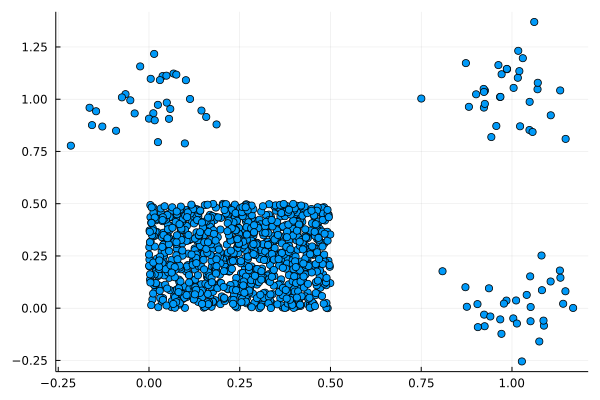

In [3]:
scatter(eachrow(malanchev_dataset())...; legend=nothing)

# Abstract tree structures

In [3]:
"Abstract tree node"
abstract type AbstractNode end

"Abstract tree itself"
abstract type AbstractForest end

"Tree is an array of nodes"
const BasicTree{N} = Vector{N}

"Forest is an array of trees. We also hold build options here."
struct BasicForest{N} <: AbstractForest
    trees::Vector{BasicTree{N}}
    options::pairs(NamedTuple)
end

"Auxiliary view type for the internal use in subtree constructions."
const SubData{F} = SubArray{F, 2, Matrix{F}, Tuple{Slice{OneTo{Int64}}, UnitRange{Int}}, true}

SubData

# Construction of trees and forest growing

In [7]:
"Isolation forest construction. For each tree we subsample n_samples out of
the initial data. Maximum depth of the constructed trees is maxdepth,
number of trees in forest is n_trees."
function build_forest(
        ::Type{BasicForest{N}},
        data::Matrix{F},
        n_trees::Int;
        rng::R=Random.GLOBAL_RNG,
        kwargs...)::BasicForest{N} where {N <: AbstractNode, F <: Real, R <: AbstractRNG}
    
    trees = Vector{BasicTree{N}}(undef, n_trees)
    
    for i in 1:n_trees
        n_samples = get(kwargs, :n_samples, 256)
        subsamples = sample(rng, axes(data, 2), n_samples; replace=false)
        subdata = data[:, subsamples]
        
        trees[i] = build_tree!(BasicForest{N}, subdata, rng; kwargs...)
    end

    return BasicForest{N}(trees, kwargs)
end


"Tree construction. The data is gonna be modified (permuted) to resemble
the division in subtrees."
function build_tree!(
        ::Type{BasicForest{N}},
        data::Matrix{F},
        rng::R;
        kwargs...)::BasicTree{N} where {N <: AbstractNode, F <: Real, R <: AbstractRNG}

    tree = Vector{N}(undef, 0)
    sizehint!(tree, size(data, 2))
    view_data = @view data[:, begin:end]
    build_subtree!(tree, Int32(0), view_data, rng; kwargs...)
    return tree[begin:end]
end


"The main function in tree construction is a construction of subtree.
Growing the whole tree is just a special case of this one."
function build_subtree!(
        tree::Vector{N},
        parent::Int32,
        subdata::SubData{F},
        rng::R;
        kwargs...)::Tuple{Int32,Int32} where {N <: AbstractNode, F <: Real, R <: AbstractRNG}
    
    node, split = make_node(tree, parent, subdata, rng; kwargs...)
    push!(tree, node)
    _, root = extrema(axes(tree, 1))

    if !split
        return (root, root)
    end

    feature, threshold = splitties(node)

    left, right = split_subarray!(subdata, feature, threshold)
    root_left, _ = build_subtree!(tree, Int32(root), left, rng; kwargs...)
    root_right, tip_right = build_subtree!(tree, Int32(root), right, rng; kwargs...)
    
    settle_node!(tree, Int32(root), Int32(root_left), Int32(root_right))

    return (root, tip_right)
end


"Splitting (permuting) the data in two halves with pivot as a threshold. The data is modified.
The algorithm is the same as in quicksort."
function split_subarray!(data::SubData{T}, feature::Int32, pivot::T)::Tuple{SubData{T}, SubData{T}} where T <: Real
    left, right = extrema(axes(data, 2))
    while true
        while data[feature, left] < pivot
            left += 1
        end

        while data[feature, right] >= pivot
            right -= 1
        end

        (left < right) || break

        (data[:, left], data[:, right]) = (data[:, right], data[:, left])
    end

    # At the point index `right` is bigger than index `left`
    vleft = @view data[:, begin:right]
    vright = @view data[:, left:end]
    return (vleft, vright)
end

split_subarray!

In [8]:
# Realization for isolation forest

"Basic tree node. It selects the `feature` and using the `threshold` decided
which subtree to go into: left one or right one.

The case feature = left = right = 0 is special for tip node.
In that case threshold means `total path length from the root`."
mutable struct BasicNode{F} <: AbstractNode
    depth::Int32
    feature::Int32
    left::Int32
    right::Int32
    threshold::F
end


"Forest is an array"
const IsolationForest{F} = BasicForest{BasicNode{F}}


function make_node(
        tree::Vector{BasicNode{F}},
        parent::Int32,
        subdata::SubData{F},
        rng::R;
        maxdepth::Int32,
        n_samples::Int32)::Tuple{BasicNode{F}, Bool} where {F <: Real, R <: AbstractRNG}
    
    first, last = extrema(axes(subdata, 2))
    n = Int32(last - first + 1)
    
    depth = (parent > 0) ? tree[parent].depth + Int32(1) : Int32(0)
    
    if (n < 2) || (depth == maxdepth)
        z = Int32(0)
        return BasicNode(depth, z, z, z, depth + average_path_length(F, n)), false
    end
    
    feature = Int32(rand(rng, axes(subdata, 1)))
    min, max = extrema(subdata[feature, :])
    threshold = min + rand(rng, F) * (max - min)
    
    z = Int32(0)
    return BasicNode(depth, feature, z, z, threshold), true
end


@inline function splitties(node::BasicNode{F})::Tuple{Int32, F} where {F <: Real}
    return node.feature, node.threshold
end


@inline function settle_node!(tree::Vector{BasicNode{F}}, root::Int32, left::Int32, right::Int32)::Nothing where F <: Real
    tree[root].left = left
    tree[root].right = right
    nothing
end


"Average path length in tree with n tip nodes."
@inline function average_path_length(::Type{T}, n::Int32)::T where T <: Real
    γ = T(MathConstants.γ)
    return n == 1 ? 0 : 2 * (log(n) + γ + 1 / 2 / n - (1 / n)^2 / 12 - 1)
end

average_path_length

# Calculation of scores

In [21]:
"Evaluation of tree path length on the given data point."
function pathlength(tree::BasicTree{BasicNode{F}}, sample::Vector{F})::F where F <: Real
    index = 1
    feature = tree[index].feature

    while feature != 0
        if sample[feature] < tree[index].threshold
            index = tree[index].left
        else
            index = tree[index].right
        end
        
        feature = tree[index].feature
    end

    return tree[index].threshold
end


"Estimation of the mean score of the given samples with the given forest."
function score(forest::IsolationForest{F}, samples::Matrix{F})::Vector{F} where F <: Real
    n_trees = length(forest.trees)

    scores = similar(Vector{F}, (axes(samples, 2),))
    scores[:] .= 0

    for i in eachindex(scores)
        for tree in forest.trees
            scores[i] += pathlength(tree, samples[:, i])
        end

        scores[i] /= n_trees
    end
    
    return -2 .^ (-scores ./ average_path_length(F, Int32(forest.options[:n_samples])))
end

score

# Example

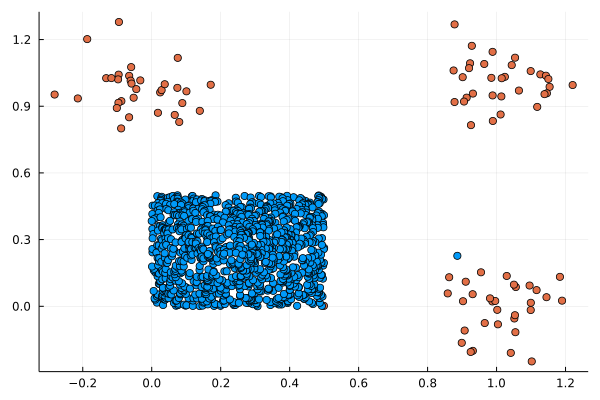

In [22]:
data = malanchev_dataset()
forest = build_forest(IsolationForest{Float32}, data, 1000; n_samples=Int32(16), maxdepth=Int32(4))
scores = score(forest, data)
sorting = sortperm(scores)

scatter(eachrow(data[:, sorting[begin:96]])...; legend=nothing, c=2)
scatter!(eachrow(data[:, sorting[97:end]])...; legend=nothing, c=1)

# Tests

In [9]:
data = malanchev_dataset(inliers=2^13);

In [12]:
@time isoforest = build_forest(IsolationForest{Float32}, data, 200; n_samples=Int32(1024), maxdepth=Int32(10));

  0.075320 seconds (688.68 k allocations: 65.393 MiB, 12.85% gc time)


# Concerns

## Harmonic number approx

In [11]:
harmonic(n::Int)::Float32 = sum(1/i for i in n:-1:1)
zero_approx(n::Int)::Float32 = log(n) + MathConstants.γ
first_approx(n::Int)::Float32 = log(n) + MathConstants.γ + 1 / (2 * n)
second_approx(n::Int)::Float32 = log(n) + MathConstants.γ + 1 / (2 * n) - 1 / (12 * n^2)

second_approx (generic function with 1 method)

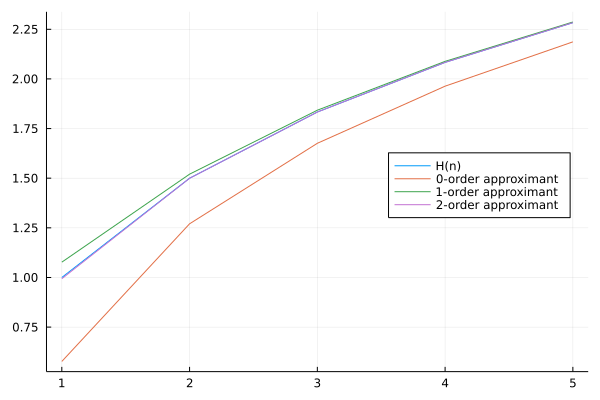

In [12]:
ns = 1:5
plot(ns, harmonic.(ns); label="H(n)", legend=:right)
plot!(ns, zero_approx.(ns); label="0-order approximant")
plot!(ns, first_approx.(ns); label="1-order approximant")
plot!(ns, second_approx.(ns); label="2-order approximant")